## Introduction


Segmentation — identifying which image pixels belong to an object — is a core task in computer vision and is used in a broad array of applications, from analyzing scientific imagery to editing photos. But creating an accurate segmentation model for specific tasks typically requires highly specialized work by technical experts with access to AI training infrastructure and large volumes of carefully annotated in-domain data.

source - https://ai.facebook.com/blog/segment-anything-foundation-model-image-segmentation/

First make sure pytorch and torchcvision are installed, for GPU
In my case: 
- pip install torch torchvision torchaudio
- pip install opencv-python matplotlib
- pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    - OR download the repo locally and install
    - and:  pip install -e .

- Download the default trained model: 
    - https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
- Other models are available:
    - https://github.com/facebookresearch/segment-anything#model-checkpoints


In [1]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.0.0
Torchvision version: 0.15.1
CUDA is available: False


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2


In [3]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

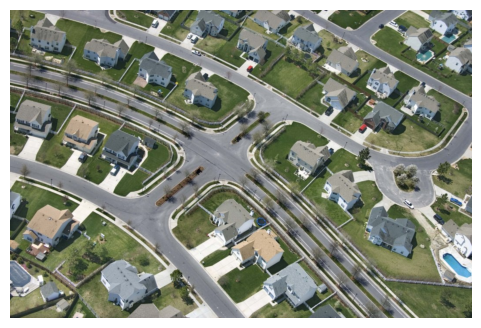

In [5]:
image = cv2.imread('houses.jpg')  #Try houses.jpg or neurons.jpg
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,4))
plt.imshow(image)
plt.axis('off')
plt.show()

In [8]:
sam_checkpoint = "../sam_vit_h_4b8939.pth"
model_type = "vit_h"

In [10]:
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
#sam.to(device=device)

- There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. 

- Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. 

- Here is an example configuration that samples more masks:
    - https://github.com/facebookresearch/segment-anything/blob/9e1eb9fdbc4bca4cd0d948b8ae7fe505d9f4ebc7/segment_anything/automatic_mask_generator.py#L35    
